In [254]:
import math
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import category_encoders as ce
font = { 'size': 12 }
matplotlib.rc('font', **font)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# **1.Thu thập dữ liệu**
- Bộ dữ liệu tham khảo về các bất động sản được cho thuê hoặc đã rao bán trong thành phố New York.
- Bộ dữ liệu gồm 2 bảng là Rent và Sold, với Rent là bảng dữ liệu các bất động sản cho thuê, Sold là bảng dữ liệu các bất động sản đã bán thành công.
- Cả hai bảng dữ liệu Rent và Sold được crawl từ trang web: https://www.realtor.com
- Code đã được up lên Github, địa chỉ repo: [URL repo](https://github.com/cur201/VisualizeData)
- Hướng dẫn lấy các file raw:
    + B1: Clone repo crawl data bằng câu lệnh "git clone https://github.com/cur201/VisualizeData".
    + B2: Mở thư mục "/res/data" trong repo đã tải về. Tại thư mục đó có chứa 2 bảng dữ liệu đã crawl với tên "rent-data.csv" và "sold-data.csv" lần lượt tương ứng với Rent và Sold.

# **2. Làm sạch dữ liệu**

### **2.1. Định nghĩa các functions**

In [255]:
#Using for rent data
def is_wrong_format(string):
    if ('Jan' in string) or ('Feb' in string):
        return True
    else:
        return False

def fix_wrong_format(date_string):
    # Parse the input date string
    date = datetime.strptime(date_string, '%d-%b')

    # Format the date as desired
    day = str(date.day)
    month = str(date.month)
    formatted_date = f"{month}-{day}"

    return formatted_date

def fix_room_data(string):
    string = string.replace(' ', '')
    if is_wrong_format(string):
        string = fix_wrong_format(string)
    return string

def is_number(x):
    try:
        int(float(x))
        return True
    except:
        return False

def isupper(string):
    if '+' in string:
        return True
    else:
        return False

def format_range_data(string):
    items = string.split('-')
    if len(items) == 2:
        if is_number(items[0]) and is_number(items[1]):
            return string
        else:
            return None
    if len(items) == 1:
        if is_number(items[0]) or isupper(items[0]):
            return string
        else:
            return None

#Using for sold data        
def isupper(string):
    if '+' in string:
        return True
    else:
        return False

def formatData(string):
    if string is None:
        return None
    else:
        if isupper(string):
            return math.ceil(float(string.rstrip('+')))
        else:
            return math.floor(float(string))

def convert_datetime(dt):
    return datetime.strftime(dt, '%Y-%m-%d')
        

### **2.2. Đọc file .csv**

In [256]:
rent_data = pd.read_csv('rent-data.csv')
sold_data = pd.read_csv('sold-data.csv')

rent_data.head()
sold_data.head()

,PRICE,MUNICIPALITY,RENTAL_TYPE,BEDROOM,BATHROOM,AREA
0,"$2,420 - $3,855","New Rochelle, NY 10801",For Rent - Apartment,2-Jan,2-Jan,"557 - 1,095"
1,"$2,424 - $3,057","Highland, NY 12528",For Rent - Apartment,3-Feb,2,"1,291 - 1,760"
2,"$2,174 - $2,603","Middletown, NY 10940",For Rent - Other,2-Jan,2-Jan,"816 - 1,231"
3,"$3,800","Glen Cove, NY 11542",For Rent - House,3,1,-
4,Contact For Price,"East Quogue, NY 11942",For Rent - House,7,9,-


,price,municipality,sold_date,property_type,bedroom,bathroom,area,year_built
0,"$235,000","Croghan, NY 13327","<span class=""jsx-3853574337 statusText"">Sold -...",Single Family,3,2,"1,830",1890
1,"$191,000","Hamburg, NY 14075","<span class=""jsx-3853574337 statusText"">Sold -...",Single Family,3,1,936,1956
2,"$275,000","Medina, NY 14103","<span class=""jsx-3853574337 statusText"">Sold -...",Single Family,3,1.5+,"1,536",2011
3,"$315,000","Ithaca, NY 14850","<span class=""jsx-3853574337 statusText"">Sold -...",Single Family,-,-,-,-
4,"$26,900","Delevan, NY 14042","<span class=""jsx-3853574337 statusText"">Sold -...",Land,-,-,-,-


### **2.3. Format dữ liệu**

In [257]:
#Format rent data
rent_data['PRICE'] = rent_data.apply(lambda row: row['PRICE'].replace('$', '').replace(',', '').replace(' ', ''), axis=1)
rent_data['MUNICIPALITY'] = rent_data.apply(lambda row: row['MUNICIPALITY'].split(', ')[0], axis=1)
rent_data['RENTAL_TYPE'] = rent_data.apply(lambda row: row['RENTAL_TYPE'].split(' - ')[1] if ' - ' in row['RENTAL_TYPE'] else row['RENTAL_TYPE'], axis=1)
rent_data['BEDROOM'] = rent_data.apply(lambda row: fix_room_data(row['BEDROOM'].replace('Studio', '1')), axis=1)
rent_data['BATHROOM'] = rent_data.apply(lambda row: fix_room_data(row['BATHROOM']) , axis=1)
rent_data['AREA'] = rent_data.apply(lambda row: row['AREA'].replace(',', '').replace(' ', ''), axis=1)
rent_data['PRICE'] = rent_data.apply(lambda row: format_range_data(row['PRICE']), axis=1)
rent_data['BEDROOM'] = rent_data.apply(lambda row: format_range_data(row['BEDROOM']), axis=1)
rent_data['BATHROOM'] = rent_data.apply(lambda row: format_range_data(row['BATHROOM']), axis=1)
rent_data['AREA'] = rent_data.apply(lambda row: format_range_data(row['AREA']), axis=1)

#Format sold data
sold_data['price'] = sold_data.apply(lambda row: row['price'].replace('$', '').replace(',', ''), axis=1)
sold_data['municipality'] = sold_data.apply(lambda row: row['municipality'].split(', ')[0], axis=1)
sold_data['sold_date'] = sold_data.apply(lambda row: re.sub(r'<[^>]+>', '', row['sold_date']).split(' - ')[1] if ' - ' in row['sold_date'] else row['sold_date'], axis=1)
sold_data['area'] = sold_data.apply(lambda row: row['area'].replace(',', ''), axis=1)
sold_data['bedroom'] = sold_data.apply(lambda row: row['bedroom'].replace('Studio', '1'), axis=1)
sold_data.replace('-', None, inplace=True)
sold_data['sold_date'] = pd.to_datetime(sold_data['sold_date'])
sold_data['sold_date'] = sold_data['sold_date'].apply(convert_datetime)

#Show the result
rent_data
sold_data

,PRICE,MUNICIPALITY,RENTAL_TYPE,BEDROOM,BATHROOM,AREA
0,2420-3855,New Rochelle,Apartment,1-2,1-2,557-1095
1,2424-3057,Highland,Apartment,2-3,2,1291-1760
2,2174-2603,Middletown,Other,1-2,1-2,816-1231
3,3800,Glen Cove,House,3,1,None
4,None,East Quogue,House,7,9,None
...,...,...,...,...,...,...
3691,2100,Bronx,Co-op,1,1,756
3692,4500,New York,Apartment,1,1,None
3693,4500,New York,Apartment,1,1,None
3694,4500,New York,Apartment,1,1,None


,price,municipality,sold_date,property_type,bedroom,bathroom,area,year_built
0,235000,Croghan,2023-07-03,Single Family,3,2,1830,1890
1,191000,Hamburg,2023-07-03,Single Family,3,1,936,1956
2,275000,Medina,2023-07-03,Single Family,3,1.5+,1536,2011
3,315000,Ithaca,2023-07-03,Single Family,None,None,None,None
4,26900,Delevan,2023-07-03,Land,None,None,None,None
...,...,...,...,...,...,...,...,...
3084,605000,Clifton Park,2023-06-29,Single Family,4,3.5+,2958,1991
3085,242500,West Seneca,2023-06-29,Townhouse,2,1.5+,1656,1990
3086,1080000,Whitestone,2023-06-30,Single Family,3,1,None,1950
3087,205000,North Tonawanda,2023-06-29,Single Family,3,1,1000,1960


### **2.4. Chỉnh sửa giá trị**

In [258]:
#Using for rent data
def split_rows(row):
    if None in [row['PRICE'], row['BEDROOM'], row['BATHROOM'], row['AREA']]:
        return [row]
    prices = row['PRICE'].split('-')
    bedrooms = row['BEDROOM'].split('-')
    bathrooms = row['BATHROOM'].split('-')
    areas = row['AREA'].split('-')
    lists = [prices, bedrooms, bathrooms, areas]
    if all(len(sub_list) == 1 for sub_list in lists):
        bedroom = math.ceil(float(bedrooms[0].rstrip('+'))) if isupper(bedrooms[0]) else math.floor(float(bedrooms[0]))
        bathroom = math.ceil(float(bathrooms[0].rstrip('+'))) if isupper(bathrooms[0]) else math.floor(float(bathrooms[0]))
        return [{'PRICE': prices[0], 'MUNICIPALITY': row['MUNICIPALITY'], 'RENTAL_TYPE': row['RENTAL_TYPE'], 'BEDROOM': bedroom, 'BATHROOM': bathroom, 'AREA': areas[0]}]
    else:
        if len(prices) == 2:
            price_0 = int(float(prices[0]))
            price_1 = int(float(prices[1]))
        else:
            price_0 = price_1 = int(float(prices[0]))

        if len(bedrooms) == 2:
            bedroom_0 = int(float(bedrooms[0]))
            bedroom_1 = int(float(bedrooms[1]))
        else:
            bedroom_0 = bedroom_1 = math.ceil(float(bedrooms[0].rstrip('+'))) if isupper(bedrooms[0]) else math.floor(float(bedrooms[0]))

        if len(bathrooms) == 2:
            bathroom_0 = int(float(bathrooms[0]))
            bathroom_1 = int(float(bathrooms[1]))
        else:
            bathroom_0 = bathroom_1 = bathroom = math.ceil(float(bathrooms[0].rstrip('+'))) if isupper(bathrooms[0]) else math.floor(float(bathrooms[0]))

        if len(areas) == 2:
            area_0 = int(float(areas[0]))
            area_1 = int(float(areas[1]))
        else:
            area_0 = area_1 = int(float(areas[0]))

        row_0 = {'PRICE': price_0, 'MUNICIPALITY': row['MUNICIPALITY'], 'RENTAL_TYPE': row['RENTAL_TYPE'], 'BEDROOM': bedroom_0, 'BATHROOM': bathroom_0, 'AREA': area_0}
        row_1 = {'PRICE': price_1, 'MUNICIPALITY': row['MUNICIPALITY'], 'RENTAL_TYPE': row['RENTAL_TYPE'], 'BEDROOM': bedroom_1, 'BATHROOM': bathroom_1, 'AREA': area_1}
        return [row_0, row_1]

rent_data_copy = rent_data.copy()
rent_list_rows = rent_data_copy.apply(split_rows, axis=1)
rent_data_result = pd.DataFrame([row for rows in rent_list_rows for row in rows])


#Using for sold data
sold_data['price'] = sold_data.apply(lambda row: formatData(row['price']), axis=1)
sold_data['bedroom'] = sold_data.apply(lambda row: formatData(row['bedroom']), axis=1)
sold_data['bathroom'] = sold_data.apply(lambda row: formatData(row['bathroom']), axis=1)
sold_data['area'] = sold_data.apply(lambda row: formatData(row['area']), axis=1)
sold_data['year_built'] = sold_data.apply(lambda row: formatData(row['year_built']), axis=1)

#Show the result
rent_data_result
sold_data


,PRICE,MUNICIPALITY,RENTAL_TYPE,BEDROOM,BATHROOM,AREA
0,2420,New Rochelle,Apartment,1,1,557
1,3855,New Rochelle,Apartment,2,2,1095
2,2424,Highland,Apartment,2,2,1291
3,3057,Highland,Apartment,3,2,1760
4,2174,Middletown,Other,1,1,816
...,...,...,...,...,...,...
4067,2100,Bronx,Co-op,1,1,756
4068,4500,New York,Apartment,1,1,None
4069,4500,New York,Apartment,1,1,None
4070,4500,New York,Apartment,1,1,None


,price,municipality,sold_date,property_type,bedroom,bathroom,area,year_built
0,235000,Croghan,2023-07-03,Single Family,3.0,2.0,1830.0,1890.0
1,191000,Hamburg,2023-07-03,Single Family,3.0,1.0,936.0,1956.0
2,275000,Medina,2023-07-03,Single Family,3.0,2.0,1536.0,2011.0
3,315000,Ithaca,2023-07-03,Single Family,NaN,NaN,NaN,NaN
4,26900,Delevan,2023-07-03,Land,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
3084,605000,Clifton Park,2023-06-29,Single Family,4.0,4.0,2958.0,1991.0
3085,242500,West Seneca,2023-06-29,Townhouse,2.0,2.0,1656.0,1990.0
3086,1080000,Whitestone,2023-06-30,Single Family,3.0,1.0,NaN,1950.0
3087,205000,North Tonawanda,2023-06-29,Single Family,3.0,1.0,1000.0,1960.0


### **2.5. Xử lý dữ liệu rỗng**

Fill các dữ liệu rỗng bằng hàm median():

In [259]:
rent_data_result = rent_data_result.fillna(rent_data_result.median())
sold_data = sold_data.fillna(sold_data.median())
rent_data_result
sold_data

C:\Users\david\AppData\Local\Temp\ipykernel_732\2733741594.py:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  rent_data_result = rent_data_result.fillna(rent_data_result.median())
C:\Users\david\AppData\Local\Temp\ipykernel_732\2733741594.py:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sold_data = sold_data.fillna(sold_data.median())


,PRICE,MUNICIPALITY,RENTAL_TYPE,BEDROOM,BATHROOM,AREA
0,2420,New Rochelle,Apartment,1,1,557
1,3855,New Rochelle,Apartment,2,2,1095
2,2424,Highland,Apartment,2,2,1291
3,3057,Highland,Apartment,3,2,1760
4,2174,Middletown,Other,1,1,816
...,...,...,...,...,...,...
4067,2100,Bronx,Co-op,1,1,756
4068,4500,New York,Apartment,1,1,1135.0
4069,4500,New York,Apartment,1,1,1135.0
4070,4500,New York,Apartment,1,1,1135.0


,price,municipality,sold_date,property_type,bedroom,bathroom,area,year_built
0,235000,Croghan,2023-07-03,Single Family,3.0,2.0,1830.0,1890.0
1,191000,Hamburg,2023-07-03,Single Family,3.0,1.0,936.0,1956.0
2,275000,Medina,2023-07-03,Single Family,3.0,2.0,1536.0,2011.0
3,315000,Ithaca,2023-07-03,Single Family,3.0,2.0,1645.0,1960.0
4,26900,Delevan,2023-07-03,Land,3.0,2.0,1645.0,1960.0
...,...,...,...,...,...,...,...,...
3084,605000,Clifton Park,2023-06-29,Single Family,4.0,4.0,2958.0,1991.0
3085,242500,West Seneca,2023-06-29,Townhouse,2.0,2.0,1656.0,1990.0
3086,1080000,Whitestone,2023-06-30,Single Family,3.0,1.0,1645.0,1950.0
3087,205000,North Tonawanda,2023-06-29,Single Family,3.0,1.0,1000.0,1960.0


Thay đổi dạng dữ liệu của cột:

In [260]:
rent_data_result = rent_data_result.astype({'PRICE': 'int', 'BEDROOM': 'int', 'BATHROOM': 'int', 'AREA': 'int'})
sold_data = sold_data.astype({'price': 'int', 'bedroom': 'int', 'bathroom': 'int', 'area': 'int', 'year_built': 'int'})
rent_data_result.info()
sold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   PRICE         4072 non-null   int32 
 1   MUNICIPALITY  4072 non-null   object
 2   RENTAL_TYPE   4072 non-null   object
 3   BEDROOM       4072 non-null   int32 
 4   BATHROOM      4072 non-null   int32 
 5   AREA          4072 non-null   int32 
dtypes: int32(4), object(2)
memory usage: 127.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3089 entries, 0 to 3088
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   price          3089 non-null   int32 
 1   municipality   3089 non-null   object
 2   sold_date      3089 non-null   object
 3   property_type  3089 non-null   object
 4   bedroom        3089 non-null   int32 
 5   bathroom       3089 non-null   int32 
 6   area           3089 non-null   int32 
 7   year_bui

Gộp các giá trị trong cột địa chỉ có mẫu số thấp thành giá trị chung:

In [261]:

location_states = rent_data_result.groupby('MUNICIPALITY')['MUNICIPALITY'].agg('count').sort_values(ascending=False)
municipality_stats_less_than_10 = location_states[location_states <= 10]
municipality_stats_less_than_10
rent_data_result['MUNICIPALITY'] = rent_data_result.MUNICIPALITY.apply(lambda x: 'Other' if x in municipality_stats_less_than_10 else x)

rent_data_result

location_states = sold_data.groupby('municipality')['municipality'].agg('count').sort_values(ascending=False)
municipality_stats_less_than_10 = location_states[location_states <= 10]
sold_data['municipality'] = sold_data.municipality.apply(lambda x: 'Other' if x in municipality_stats_less_than_10 else x)

sold_data

MUNICIPALITY
Clifton Park       10
Yaphank            10
Saratoga County    10
Water Mill          9
Quogue              9
                   ..
Palmyra             1
Glen Spey           1
Pearl River         1
Peconic             1
Accord              1
Name: MUNICIPALITY, Length: 354, dtype: int64

,PRICE,MUNICIPALITY,RENTAL_TYPE,BEDROOM,BATHROOM,AREA
0,2420,New Rochelle,Apartment,1,1,557
1,3855,New Rochelle,Apartment,2,2,1095
2,2424,Other,Apartment,2,2,1291
3,3057,Other,Apartment,3,2,1760
4,2174,Other,Other,1,1,816
...,...,...,...,...,...,...
4067,2100,Bronx,Co-op,1,1,756
4068,4500,New York,Apartment,1,1,1135
4069,4500,New York,Apartment,1,1,1135
4070,4500,New York,Apartment,1,1,1135


,price,municipality,sold_date,property_type,bedroom,bathroom,area,year_built
0,235000,Other,2023-07-03,Single Family,3,2,1830,1890
1,191000,Hamburg,2023-07-03,Single Family,3,1,936,1956
2,275000,Other,2023-07-03,Single Family,3,2,1536,2011
3,315000,Ithaca,2023-07-03,Single Family,3,2,1645,1960
4,26900,Other,2023-07-03,Land,3,2,1645,1960
...,...,...,...,...,...,...,...,...
3084,605000,Clifton Park,2023-06-29,Single Family,4,4,2958,1991
3085,242500,West Seneca,2023-06-29,Townhouse,2,2,1656,1990
3086,1080000,Other,2023-06-30,Single Family,3,1,1645,1950
3087,205000,North Tonawanda,2023-06-29,Single Family,3,1,1000,1960


# **3. Trích xuất đặc trưng**

### **3.1. Phân tích và trực quan hóa dữ liệu**

#### **3.1.1. Quan sát kiểu dữ liệu của các đặc trưng:**

In [262]:
obj = (rent_data_result.dtypes == 'object')
object_cols = list(obj[obj].index)
print('Categorical variables', object_cols)

int_ = (rent_data_result.dtypes == 'int32')
num_cols = list(int_[int_].index)
print("Integer variables:", num_cols)

obj = (sold_data.dtypes == 'object')
object_cols = list(obj[obj].index)
print('Categorical variables', object_cols)

int_ = (sold_data.dtypes == 'int32')
num_cols = list(int_[int_].index)
print("Integer variables:", num_cols)

Categorical variables ['MUNICIPALITY', 'RENTAL_TYPE']
Integer variables: ['PRICE', 'BEDROOM', 'BATHROOM', 'AREA']
Categorical variables ['municipality', 'sold_date', 'property_type']
Integer variables: ['price', 'bedroom', 'bathroom', 'area', 'year_built']


#### **3.1.2. Mô hình hóa sự tương quan giữa các đặc trưng:**

<Figure size 1000x600 with 0 Axes>

<Axes: >

<Figure size 1200x600 with 0 Axes>

C:\Users\david\AppData\Local\Temp\ipykernel_732\4004111291.py:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(sold_data_encoded.corr(), cmap="coolwarm", annot=True, fmt=".2f")


<Axes: >

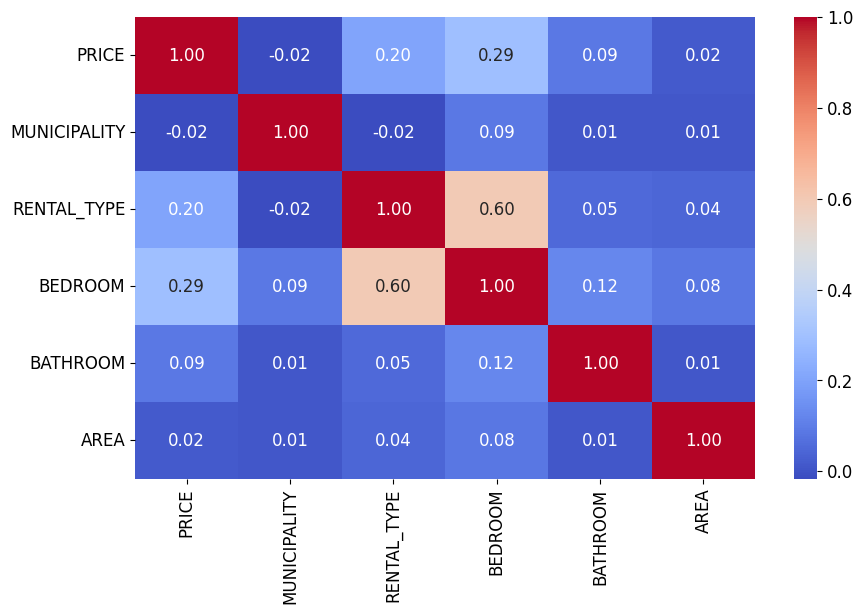

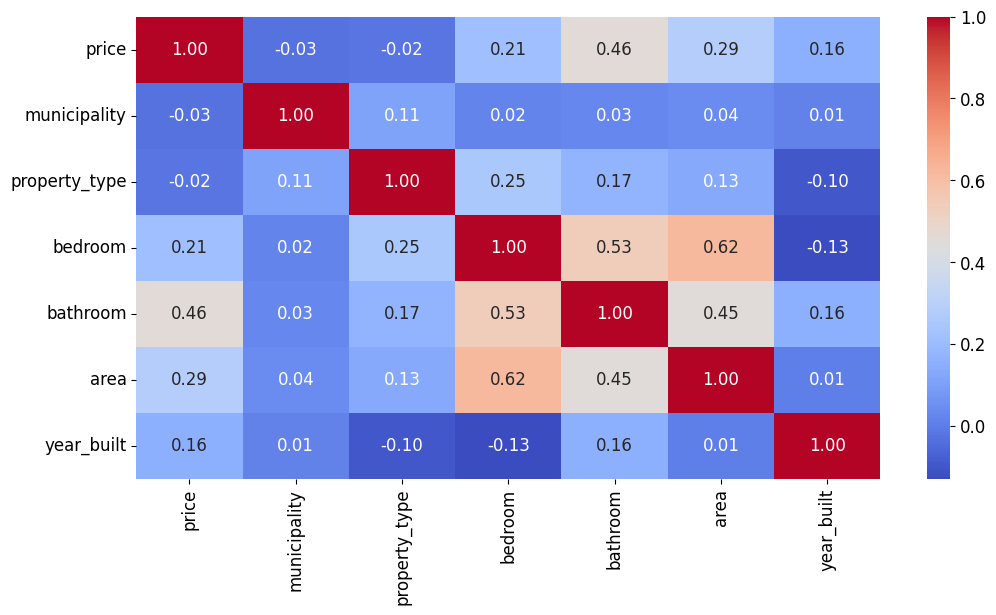

In [263]:
rent_data_encoded = rent_data_result.copy()
rent_data_encoded["MUNICIPALITY"] = rent_data_encoded["MUNICIPALITY"].astype("category").cat.codes
rent_data_encoded["RENTAL_TYPE"] = rent_data_encoded["RENTAL_TYPE"].astype("category").cat.codes

plt.figure(figsize=(10, 6))
sns.heatmap(rent_data_encoded.corr(), cmap="coolwarm", annot=True, fmt=".2f")
#plt.show()

sold_data_encoded = sold_data.copy()
sold_data_encoded["municipality"] = sold_data_encoded["municipality"].astype("category").cat.codes
sold_data_encoded["property_type"] = sold_data_encoded["property_type"].astype("category").cat.codes
plt.figure(figsize=(12, 6))
sns.heatmap(sold_data_encoded.corr(), cmap="coolwarm", annot=True, fmt=".2f")

Theo bảng trực quan hóa dữ liệu, ta có thể thấy độ tương quan của Price khá thấp và không đồng nhất giữa 2 bộ dữ liệu:
- Ở Rent, Price có độ tương quan cao nhất với Bedroom (0.31) và Rental Type (0.23).
- Ở Sold, Price có độ tương quan cao nhất với Bedroom (0.21), Bathroom (0.46) và Area (0.29).

In [264]:
def visualize_pie_chart(data, attribute, threshold):
    threshold_value = threshold
    attribute_counts = data[attribute].value_counts()
    major_values = attribute_counts[attribute_counts >= threshold_value].index.tolist()
    minor_values = attribute_counts[attribute_counts < threshold_value].index.tolist()

    data[attribute] = data[attribute].apply(lambda x: 'Other' if x in minor_values else x)

    attribute_counts = data[attribute].value_counts()
    labels = attribute_counts.index.tolist()
    values = attribute_counts.values.tolist()

    fig, ax = plt.subplots()
    pie = ax.pie(values, labels=labels, startangle=90)

    ax.axis('equal')  

    legend_labels = ['{} - {}'.format(label, value) for label, value in zip(labels, values)]
    plt.legend(pie[0], legend_labels, loc='lower right', bbox_to_anchor=(2.5, 0.25))
    
    plt.title(attribute + ' Distribution')

    for text in pie[1]:
        text.set_visible(False)

    plt.show()

def visualize_bar_chart(data, attribute, threshold):
    attribute_counts = data[attribute].value_counts()
    major_values = attribute_counts[attribute_counts >= threshold].index.tolist()
    minor_values = attribute_counts[attribute_counts < threshold].index.tolist()

    data[attribute] = data[attribute].apply(lambda x: 'Other' if x in minor_values else x)

    attribute_counts = data[attribute].value_counts()
    labels = attribute_counts.index.tolist()
    values = attribute_counts.values.tolist()

    fig = plt.figure(figsize = (10, 5))

    bar = plt.bar(labels, values, width = 0.7)

    plt.title(attribute + ' Distribution')

    print('[' + ', '.join([f"{label}: {value}" for label, value in zip(labels, values)]) + ']')

    plt.show()

def visualize_scatter_plot(data, attribute1, attribute2, target):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=data, x=attribute1, y=attribute2, hue=target,palette=sns.color_palette("hls",10), legend="full")
    plt.xlabel(attribute1)
    plt.ylabel(attribute2)
    plt.title("Correlation between {}, {} and {}".format(attribute1, attribute2, target))
    plt.show()

    


#### **3.1.3. Mô tả các một số đặc trưng trong tập dữ liệu rent:**

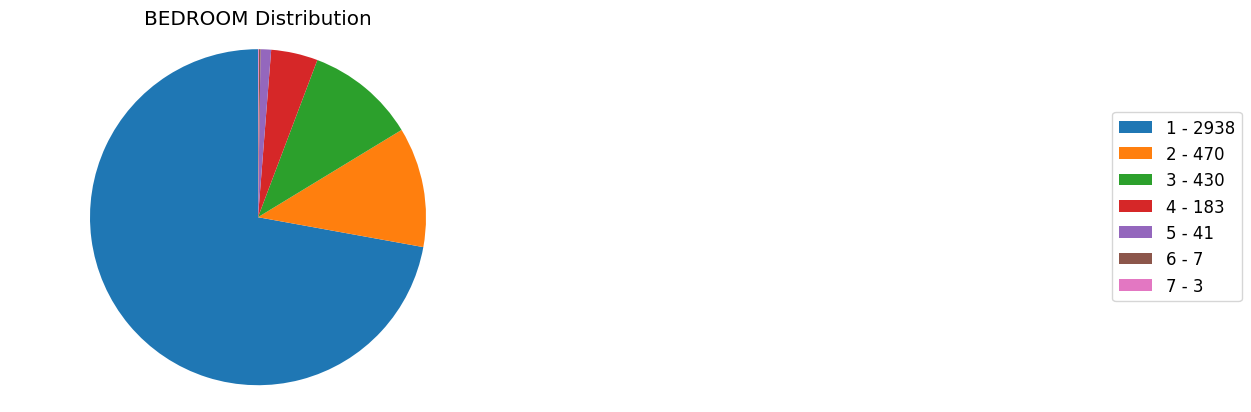

[Apartment: 3160, House: 750, Other: 68, Condo: 58, Co-op: 17, Townhome: 14, Duplex/Triplex: 5]


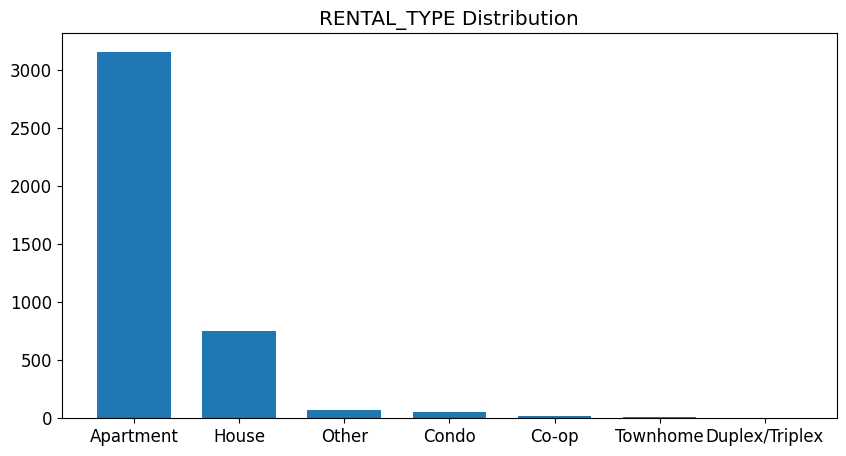

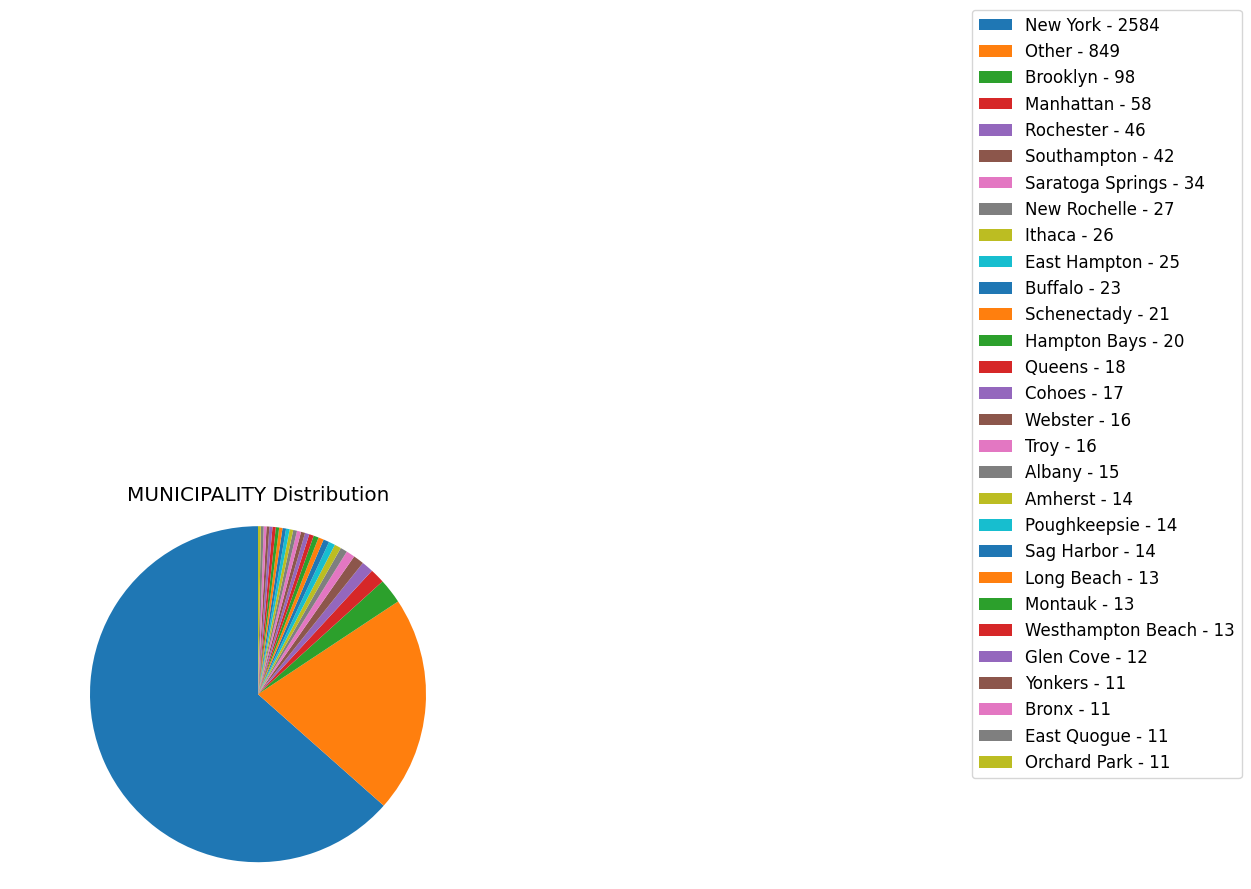

C:\Users\david\AppData\Local\Temp\ipykernel_732\1921936201.py:51: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(data=data, x=attribute1, y=attribute2, hue=target,palette=sns.color_palette("hls",10), legend="full")


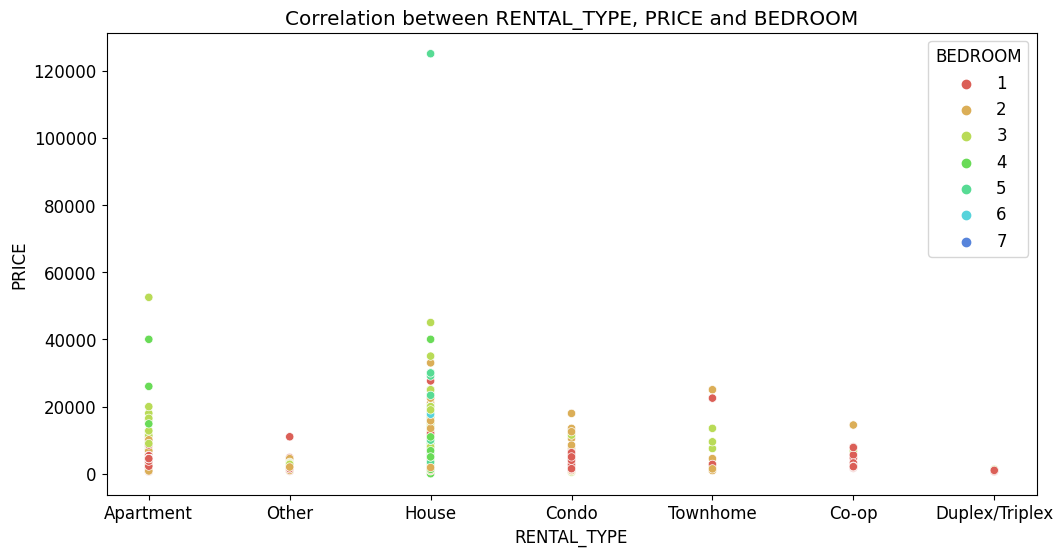

In [265]:
visualize_pie_chart(rent_data_result, 'BEDROOM', 1)
visualize_bar_chart(rent_data_result, 'RENTAL_TYPE', 1)
visualize_pie_chart(rent_data_result, 'MUNICIPALITY', 1)
visualize_scatter_plot(rent_data_result, 'RENTAL_TYPE', 'PRICE', 'BEDROOM')

Loại bỏ giá trị ngoại biên, sau đó visual lại:

C:\Users\david\AppData\Local\Temp\ipykernel_732\1921936201.py:51: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(data=data, x=attribute1, y=attribute2, hue=target,palette=sns.color_palette("hls",10), legend="full")


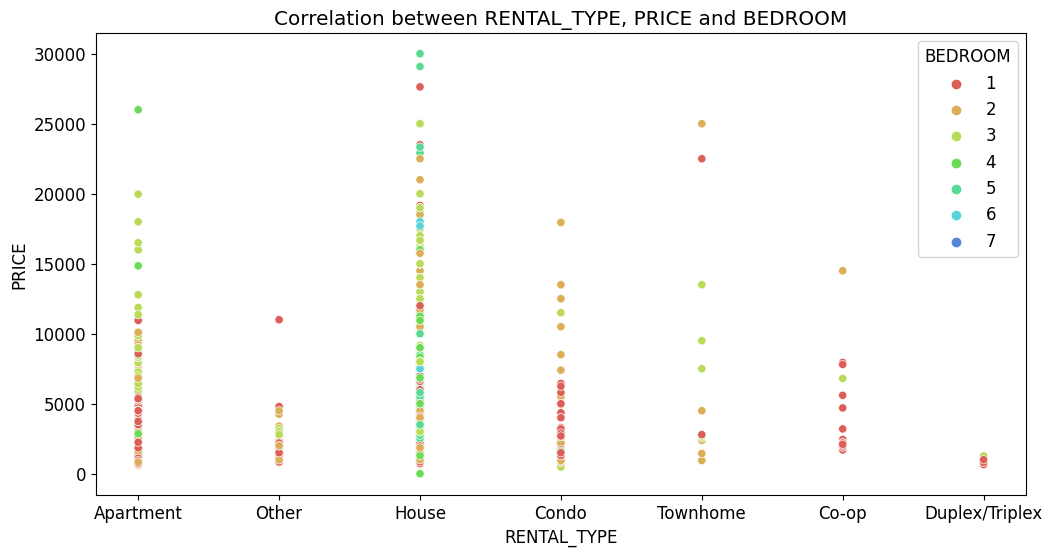

In [266]:

rent_data_result = rent_data_result[rent_data_result['PRICE'] <= 30000]
visualize_scatter_plot(rent_data_result, 'RENTAL_TYPE', 'PRICE', 'BEDROOM')

#### **3.1.4. Mô tả các một số đặc trưng trong tập dữ liệu sold:**

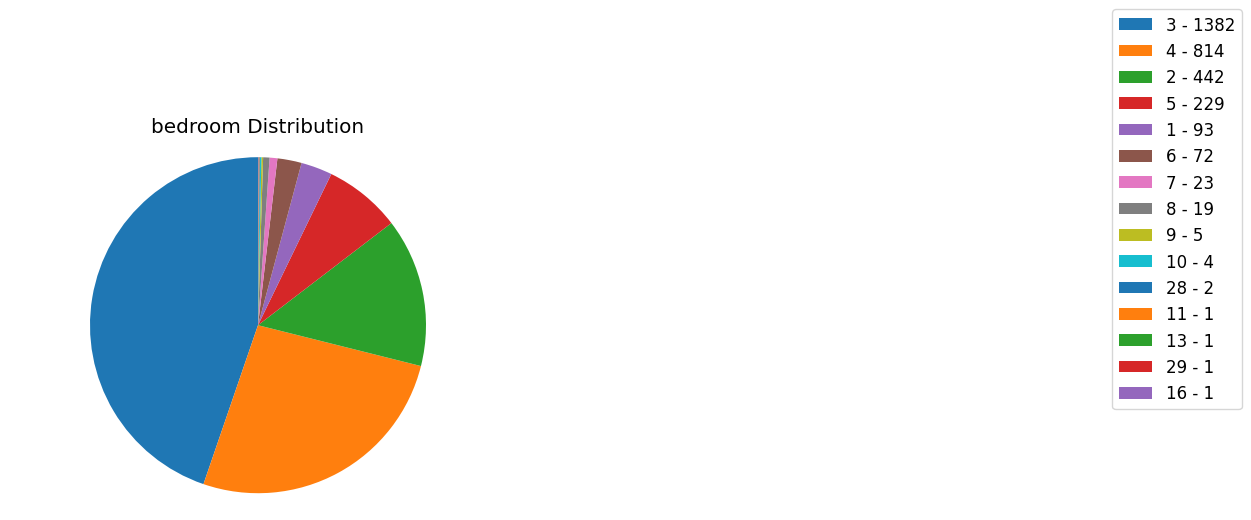

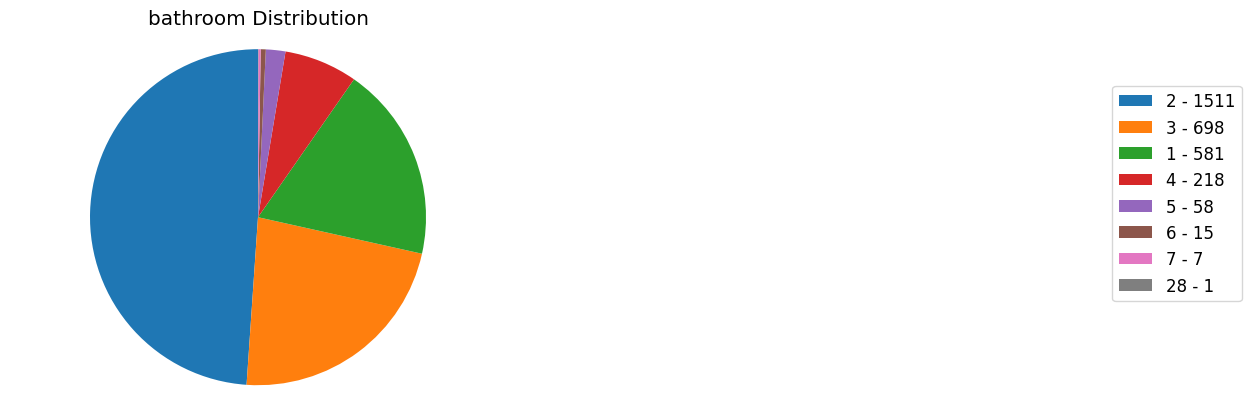

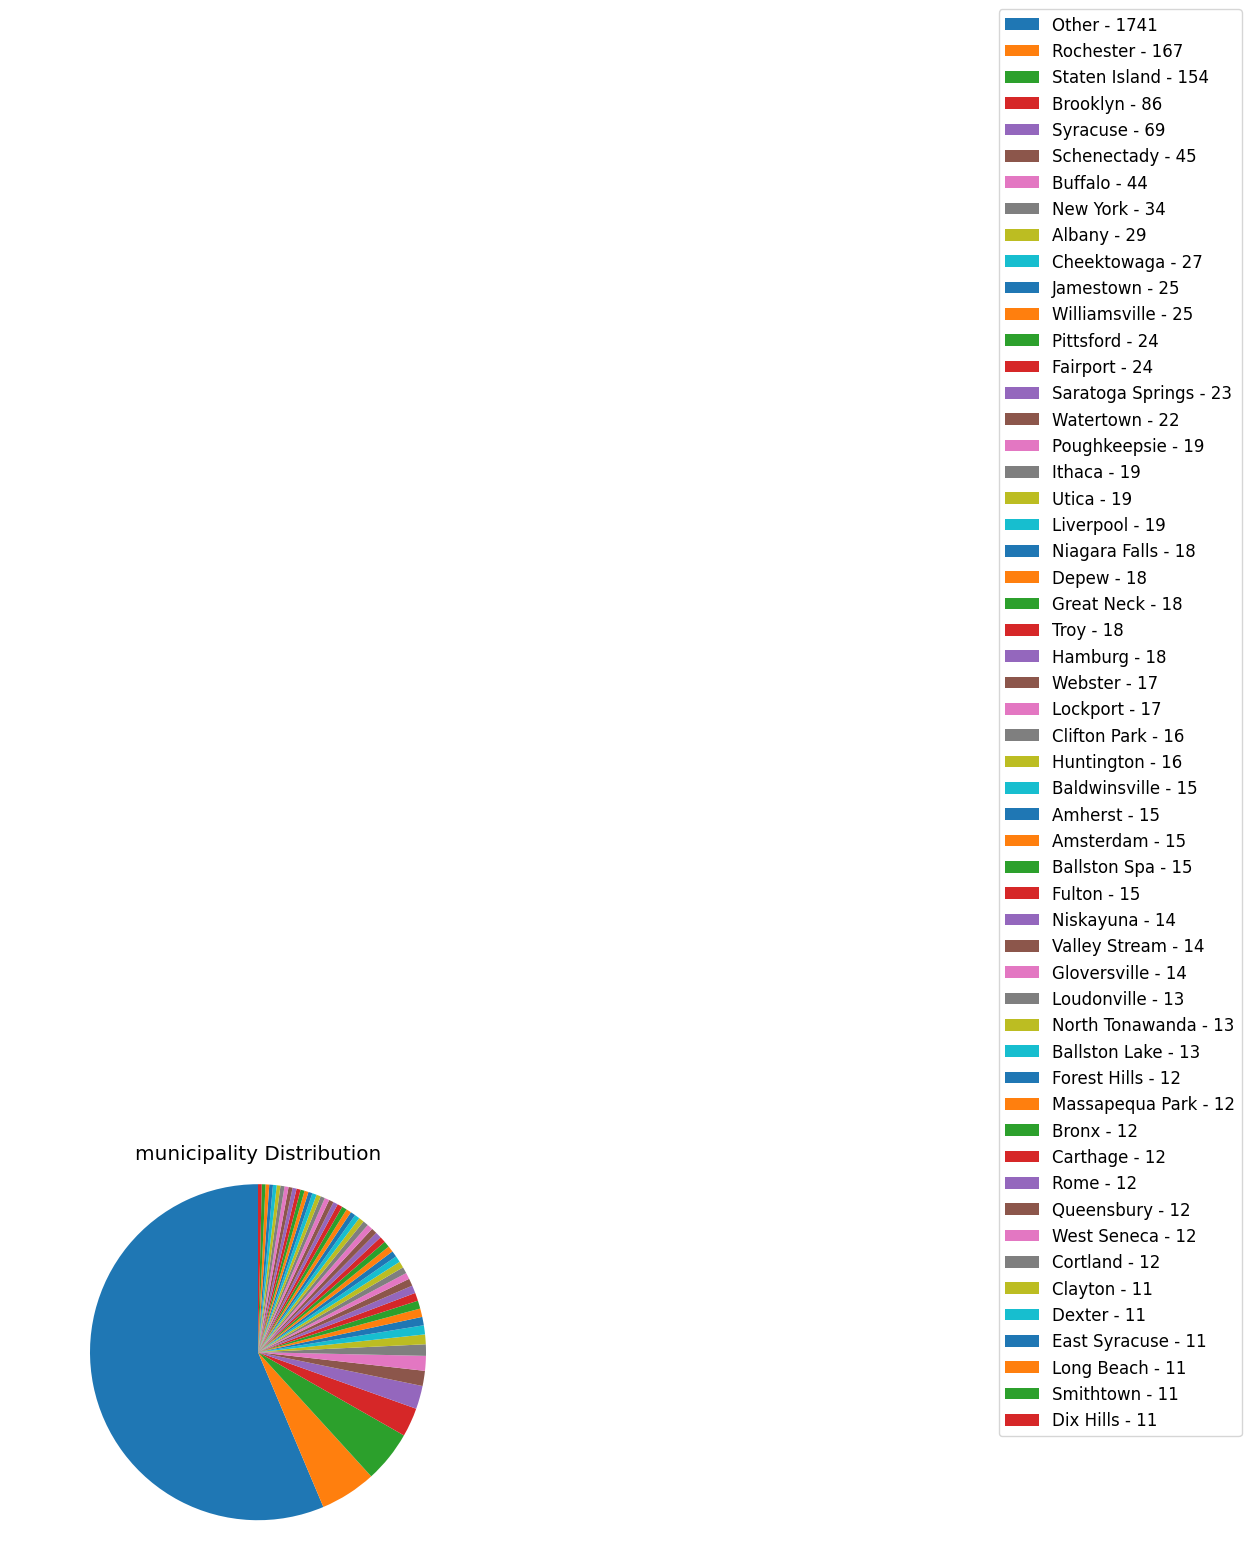

[Single Family: 2268, Multi Family: 220, Condo: 157, Land: 147, Co Op: 120, Townhouse: 118, Mobile: 56, Farm: 3]


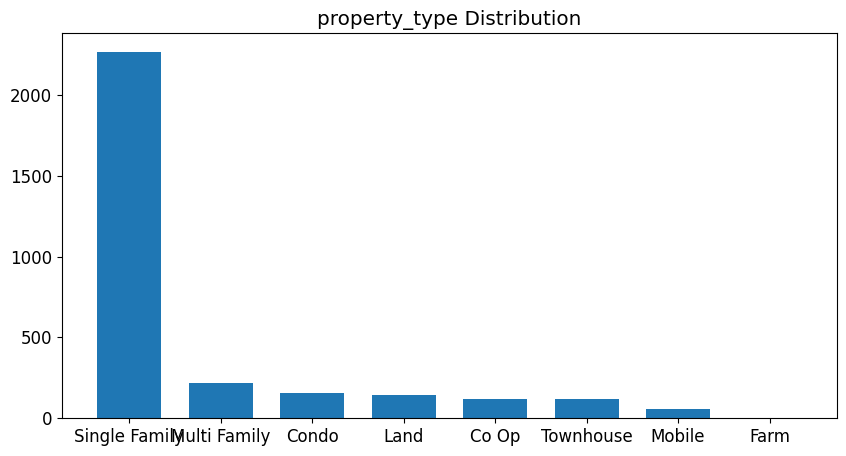

C:\Users\david\AppData\Local\Temp\ipykernel_732\1921936201.py:51: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.scatterplot(data=data, x=attribute1, y=attribute2, hue=target,palette=sns.color_palette("hls",10), legend="full")


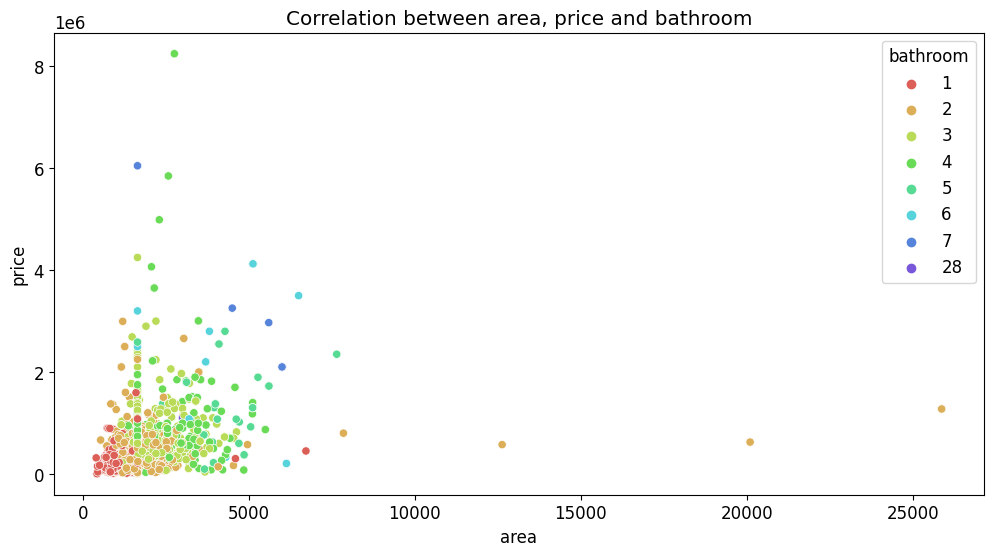

C:\Users\david\AppData\Local\Temp\ipykernel_732\1921936201.py:51: UserWarning: 
The palette list has fewer values (10) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=data, x=attribute1, y=attribute2, hue=target,palette=sns.color_palette("hls",10), legend="full")


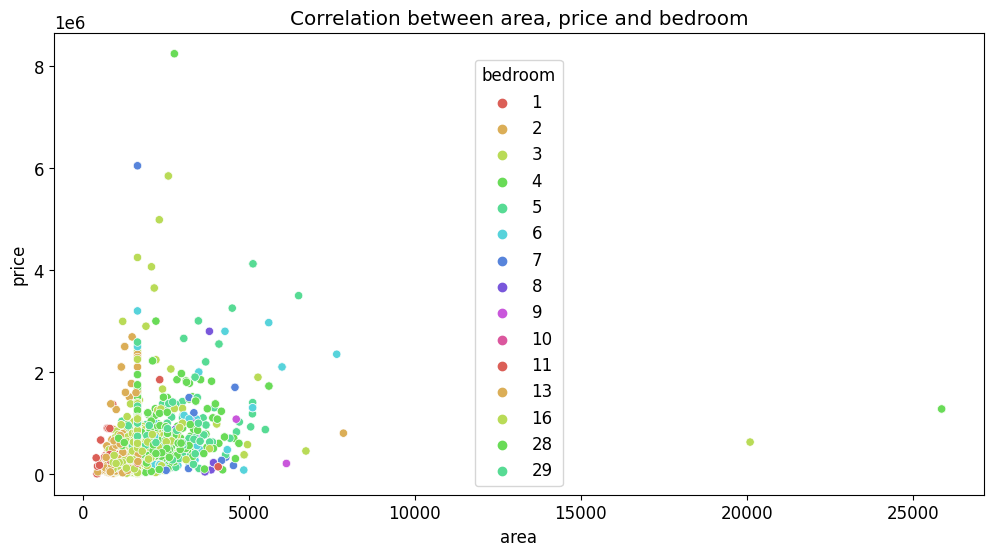

In [267]:
visualize_pie_chart(sold_data, 'bedroom', 1)
visualize_pie_chart(sold_data, 'bathroom', 1)
visualize_pie_chart(sold_data, 'municipality', 1)
visualize_bar_chart(sold_data, 'property_type', 1)
visualize_scatter_plot(sold_data, 'area', 'price', 'bathroom')
visualize_scatter_plot(sold_data, 'area', 'price', 'bedroom')

Loại bỏ giá trị biên, sau đó visual lại:

C:\Users\david\AppData\Local\Temp\ipykernel_732\1921936201.py:51: UserWarning: The palette list has more values (10) than needed (7), which may not be intended.
  sns.scatterplot(data=data, x=attribute1, y=attribute2, hue=target,palette=sns.color_palette("hls",10), legend="full")


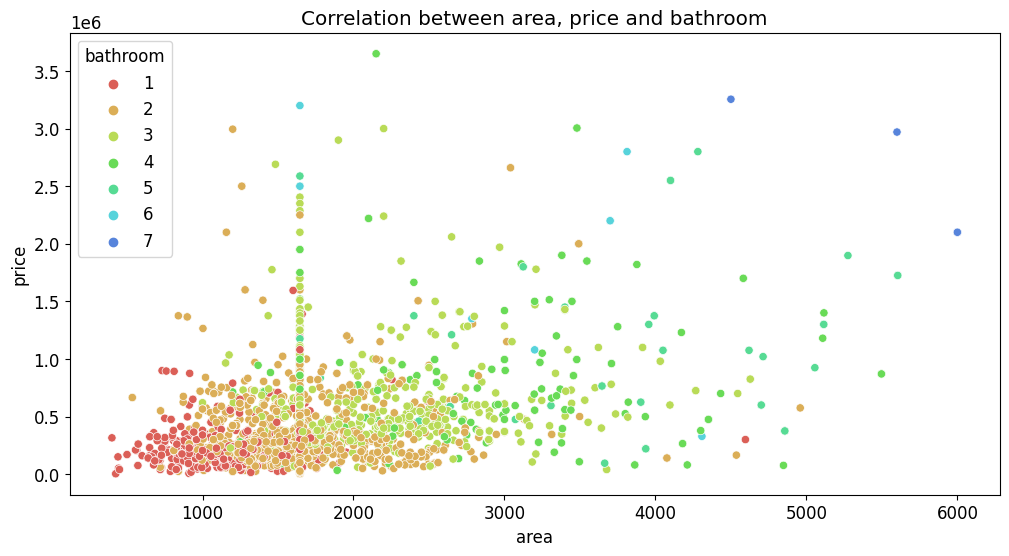

C:\Users\david\AppData\Local\Temp\ipykernel_732\1921936201.py:51: UserWarning: 
The palette list has fewer values (10) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=data, x=attribute1, y=attribute2, hue=target,palette=sns.color_palette("hls",10), legend="full")


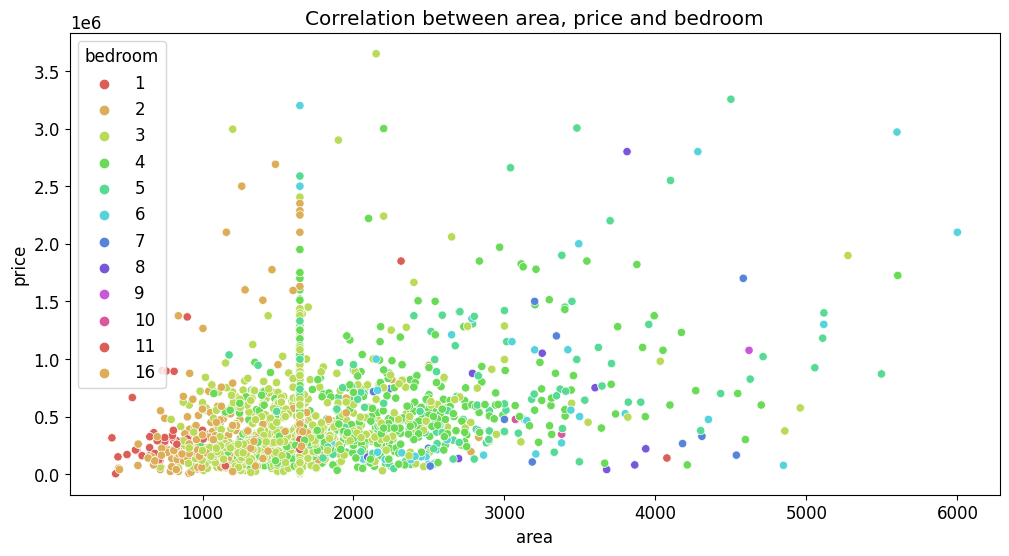

In [268]:
sold_data = sold_data[sold_data['area'] <= 6000]
sold_data = sold_data[sold_data['price'] <= 4000000]
sold_data = sold_data[sold_data['bathroom'] <= 7]
sold_data = sold_data[sold_data['bedroom'] <= 28]

visualize_scatter_plot(sold_data, 'area', 'price', 'bathroom')
visualize_scatter_plot(sold_data, 'area', 'price', 'bedroom')

### **3.2. Convert categorical data into binary vectors**

Do Municipality, Rental Type (Property Type), Sold Date là dữ liệu dạng Nominal, nên sẽ sử dụng Binary encoder để mã hóa chúng.


In [269]:
#Using for rent data
rent_obj = (rent_data_result.dtypes == 'object')
rent_object_cols = list(rent_obj[rent_obj].index)
print('Categorical variables', rent_object_cols)

rent_int_ = (rent_data_result.dtypes == 'int32')
rent_num_cols = list(rent_int_[rent_int_].index)
print("Integer variables:", rent_num_cols)

rent_b_encoder = ce.BinaryEncoder(rent_data_result[rent_object_cols], return_df=True)
rent_b_cols = pd.DataFrame(rent_b_encoder.fit_transform(rent_data_result[rent_object_cols]))
rent_b_cols.index = rent_data_result.index
rent_b_cols.columns = rent_b_encoder.get_feature_names_out()
rent_data_b_final = rent_data_result.drop(rent_object_cols, axis=1)
rent_data_b_final = pd.concat([rent_data_b_final, rent_b_cols], axis=1)

rent_data_b_final

#rent_data_final['RENTAL_TYPE'], _ = pd.factorize(rent_data_final['RENTAL_TYPE'])

OH_encoder = OneHotEncoder(sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(rent_data_result[rent_object_cols]))
OH_cols.index = rent_data_result.index
OH_cols.columns = OH_encoder.get_feature_names_out()
rent_data_OH_final = rent_data_result.drop(rent_object_cols, axis=1)
rent_data_OH_final = pd.concat([rent_data_OH_final, OH_cols], axis=1)

rent_data_OH_final

#Using for sold data
sold_obj = (sold_data.dtypes == 'object')
sold_object_cols = list(sold_obj[sold_obj].index)
print('Categorical variables', sold_object_cols)

sold_int_ = (sold_data.dtypes == 'int32')
sold_num_cols = list(sold_int_[sold_int_].index)
print("Integer variables:", sold_num_cols)

sold_b_encoder = ce.BinaryEncoder(sold_data[sold_object_cols], return_df=True)
sold_b_cols = pd.DataFrame(sold_b_encoder.fit_transform(sold_data[sold_object_cols]))
sold_b_cols.index = sold_data.index
sold_b_cols.columns = sold_b_encoder.get_feature_names_out()
sold_data_b_final = sold_data.drop(sold_object_cols, axis=1)
sold_data_b_final = pd.concat([sold_data_b_final, sold_b_cols], axis=1)

sold_data_b_final

OH_encoder = OneHotEncoder(sparse=False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(sold_data[sold_object_cols]))
OH_cols.index = sold_data.index
OH_cols.columns = OH_encoder.get_feature_names_out()
sold_data_OH_final = sold_data.drop(sold_object_cols, axis=1)
sold_data_OH_final = pd.concat([sold_data_OH_final, OH_cols], axis=1)

sold_data_OH_final

Categorical variables ['MUNICIPALITY', 'RENTAL_TYPE']
Integer variables: ['PRICE', 'BATHROOM', 'AREA']


,PRICE,BEDROOM,BATHROOM,AREA,MUNICIPALITY_0,MUNICIPALITY_1,MUNICIPALITY_2,MUNICIPALITY_3,MUNICIPALITY_4,RENTAL_TYPE_0,RENTAL_TYPE_1,RENTAL_TYPE_2
0,2420,1,1,557,0,0,0,0,1,0,0,1
1,3855,2,2,1095,0,0,0,0,1,0,0,1
2,2424,2,2,1291,0,0,0,1,0,0,0,1
3,3057,3,2,1760,0,0,0,1,0,0,0,1
4,2174,1,1,816,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4067,2100,1,1,756,0,0,1,1,0,1,1,0
4068,4500,1,1,1135,0,0,0,1,1,0,0,1
4069,4500,1,1,1135,0,0,0,1,1,0,0,1
4070,4500,1,1,1135,0,0,0,1,1,0,0,1


c:\Users\david\.conda\envs\crawler_env\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,PRICE,BEDROOM,BATHROOM,AREA,MUNICIPALITY_Albany,MUNICIPALITY_Amherst,MUNICIPALITY_Bronx,MUNICIPALITY_Brooklyn,MUNICIPALITY_Buffalo,MUNICIPALITY_Cohoes,...,MUNICIPALITY_Webster,MUNICIPALITY_Westhampton Beach,MUNICIPALITY_Yonkers,RENTAL_TYPE_Apartment,RENTAL_TYPE_Co-op,RENTAL_TYPE_Condo,RENTAL_TYPE_Duplex/Triplex,RENTAL_TYPE_House,RENTAL_TYPE_Other,RENTAL_TYPE_Townhome
0,2420,1,1,557,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3855,2,2,1095,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2424,2,2,1291,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3057,3,2,1760,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2174,1,1,816,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4067,2100,1,1,756,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4068,4500,1,1,1135,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4069,4500,1,1,1135,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4070,4500,1,1,1135,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Categorical variables ['municipality', 'sold_date', 'property_type']
Integer variables: ['price', 'area', 'year_built']


,price,bedroom,bathroom,area,year_built,municipality_0,municipality_1,municipality_2,municipality_3,municipality_4,municipality_5,sold_date_0,sold_date_1,sold_date_2,sold_date_3,property_type_0,property_type_1,property_type_2,property_type_3
0,235000,3,2,1830,1890,0,0,0,0,0,1,0,0,0,1,0,0,0,1
1,191000,3,1,936,1956,0,0,0,0,1,0,0,0,0,1,0,0,0,1
2,275000,3,2,1536,2011,0,0,0,0,0,1,0,0,0,1,0,0,0,1
3,315000,3,2,1645,1960,0,0,0,0,1,1,0,0,0,1,0,0,0,1
4,26900,3,2,1645,1960,0,0,0,0,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3084,605000,4,4,2958,1991,0,1,0,0,1,1,0,1,0,0,0,0,0,1
3085,242500,2,2,1656,1990,0,1,1,1,1,0,0,1,0,0,0,1,0,0
3086,1080000,3,1,1645,1950,0,0,0,0,0,1,0,0,1,1,0,0,0,1
3087,205000,3,1,1000,1960,0,0,1,1,0,1,0,1,0,0,0,0,0,1


c:\Users\david\.conda\envs\crawler_env\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,price,bedroom,bathroom,area,year_built,municipality_Albany,municipality_Amherst,municipality_Amsterdam,municipality_Baldwinsville,municipality_Ballston Lake,...,sold_date_2023-07-02,sold_date_2023-07-03,property_type_Co Op,property_type_Condo,property_type_Farm,property_type_Land,property_type_Mobile,property_type_Multi Family,property_type_Single Family,property_type_Townhouse
0,235000,3,2,1830,1890,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,191000,3,1,936,1956,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,275000,3,2,1536,2011,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,315000,3,2,1645,1960,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,26900,3,2,1645,1960,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3084,605000,4,4,2958,1991,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3085,242500,2,2,1656,1990,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3086,1080000,3,1,1645,1950,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3087,205000,3,1,1000,1960,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# **4. Build Model**
## **4.1. Sử dụng Linear Regression**

In [270]:
#Rent data
rent_X_OH = rent_data_OH_final.drop(['PRICE'], axis=1)
rent_Y_OH = rent_data_OH_final['PRICE']
rent_X_train_LR, rent_X_test_LR, rent_Y_train_LR, rent_Y_test_LR = train_test_split(rent_X_OH, rent_Y_OH, train_size=0.8, test_size=0.2, random_state=10)

rent_model_LR = LinearRegression()
rent_model_LR.fit(rent_X_train_LR, rent_Y_train_LR)
rent_model_LR.score(rent_X_train_LR, rent_Y_train_LR)
rent_model_LR.score(rent_X_test_LR, rent_Y_test_LR)

rent_Y_pred_LR = rent_model_LR.predict(rent_X_test_LR)
rent_mae = mean_absolute_error(rent_Y_test_LR, rent_Y_pred_LR)
print(f'Mean Absolute Error (Linear Regression) for Rent data: {rent_mae}')

#Sold data
sold_X = sold_data_OH_final.drop(['price'], axis=1)
sold_Y = sold_data_OH_final['price']
sold_X_train_LR, sold_X_test_LR, sold_Y_train_LR, sold_Y_test_LR = train_test_split(sold_X, sold_Y, train_size=0.8, test_size=0.2, random_state=10)

sold_model_LR = LinearRegression()
sold_model_LR.fit(sold_X_train_LR, sold_Y_train_LR)
sold_model_LR.score(sold_X_train_LR, sold_Y_train_LR)
sold_model_LR.score(sold_X_test_LR, sold_Y_test_LR)

sold_Y_pred_LR = sold_model_LR.predict(sold_X_test_LR)
sold_mae = mean_absolute_error(sold_Y_test_LR, sold_Y_pred_LR)
print(f'Mean Absolute Error (Linear Regression) for Sold data: {sold_mae}')


LinearRegression()

0.4006763349517448

0.4403509077299348

Mean Absolute Error (Linear Regression) for Rent data: 915.7673213420776


LinearRegression()

0.4850625414687031

0.5078475143746883

Mean Absolute Error (Linear Regression) for Sold data: 203562.42944535075


Text(0.5, 0, 'Actual')

Text(0, 0.5, 'Predicted')

Text(0.5, 1.0, 'Comparison between Predicted and Actual Values in Rent data using Linear Regression')

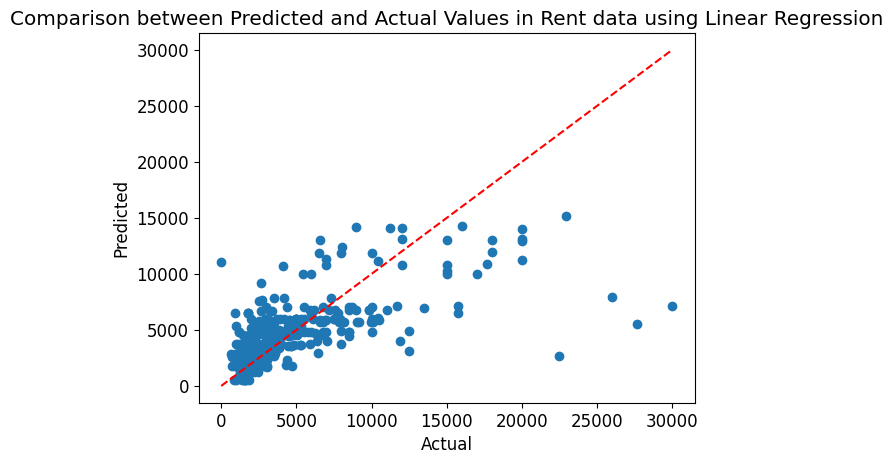

In [271]:
plt.scatter(rent_Y_test_LR, rent_Y_pred_LR)
plt.plot([min(rent_Y_test_LR), max(rent_Y_test_LR)], [min(rent_Y_test_LR), max(rent_Y_test_LR)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Comparison between Predicted and Actual Values in Rent data using Linear Regression')
plt.show()

Text(0.5, 0, 'Actual')

Text(0, 0.5, 'Predicted')

Text(0.5, 1.0, 'Comparison between Predicted and Actual Values in Sold data using Linear Regression')

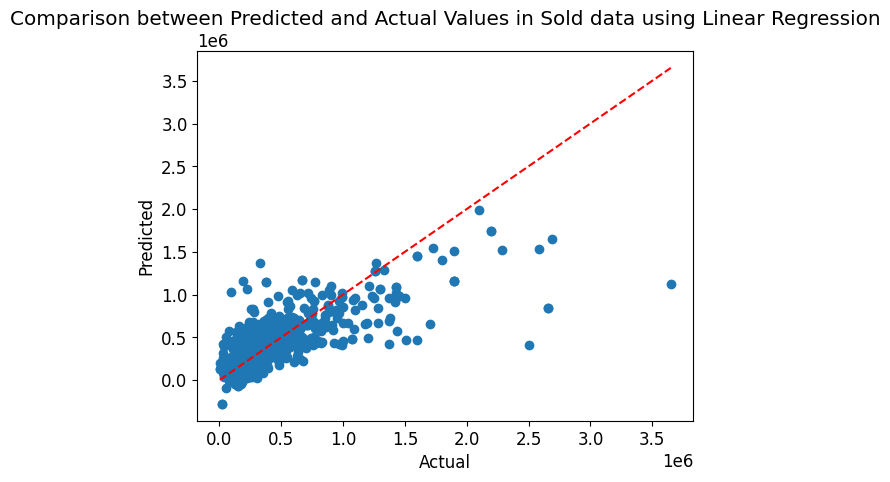

In [272]:
plt.scatter(sold_Y_test_LR, sold_Y_pred_LR)
plt.plot([min(sold_Y_test_LR), max(sold_Y_test_LR)], [min(sold_Y_test_LR), max(sold_Y_test_LR)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Comparison between Predicted and Actual Values in Sold data using Linear Regression')
plt.show()

## **4.2. Sử dụng Random Forest Regressor**

In [275]:
# Using for rent data

rent_X_b = rent_data_b_final.drop(['PRICE'], axis=1)
rent_Y_b = rent_data_b_final['PRICE']
rent_X_train_rf, rent_X_test_rf, rent_Y_train_rf, rent_Y_test_rf = train_test_split(rent_X_b, rent_Y_b, train_size=0.8, test_size=0.2, random_state=10)

rent_model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

rent_model_rf.fit(rent_X_train_rf, rent_Y_train_rf)

rent_model_rf.score(rent_X_train_rf, rent_Y_train_rf)
rent_model_rf.score(rent_X_test_rf, rent_Y_test_rf)

rent_Y_pred_rf = rent_model_rf.predict(rent_X_test_rf)
rent_mae_rf = mean_absolute_error(rent_Y_test_rf, rent_Y_pred_rf)
print(f'Mean Absolute Error (RandomForest Regression) for Rent data: {rent_mae_rf}')

# Using for sold data

sold_X_train_rf, sold_X_test_rf, sold_Y_train_rf, sold_Y_test_rf = train_test_split(sold_X, sold_Y, train_size=0.8, test_size=0.2, random_state=10)

sold_model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

sold_model_rf.fit(sold_X_train_rf, sold_Y_train_rf)

sold_model_rf.score(sold_X_train_rf, sold_Y_train_rf)
sold_model_rf.score(sold_X_test_rf, sold_Y_test_rf)

sold_Y_pred_rf = sold_model_rf.predict(sold_X_test_rf)
sold_mae_rf = mean_absolute_error(sold_Y_test_rf, sold_Y_pred_rf)
print(f'Mean Absolute Error (RandomForest Regression) for Sold data: {sold_mae_rf}')

RandomForestRegressor(random_state=42)

0.8854388391432819

0.6336117430441801

Mean Absolute Error (RandomForest Regression) for Rent data: 685.1706096411984


RandomForestRegressor(random_state=42)

0.9471840237148319

0.663691648782724

Mean Absolute Error (RandomForest Regression) for Sold data: 121224.86703526313


Text(0.5, 0, 'Actual')

Text(0, 0.5, 'Predicted')

Text(0.5, 1.0, 'Comparison between Predicted and Actual Values in Rent data')

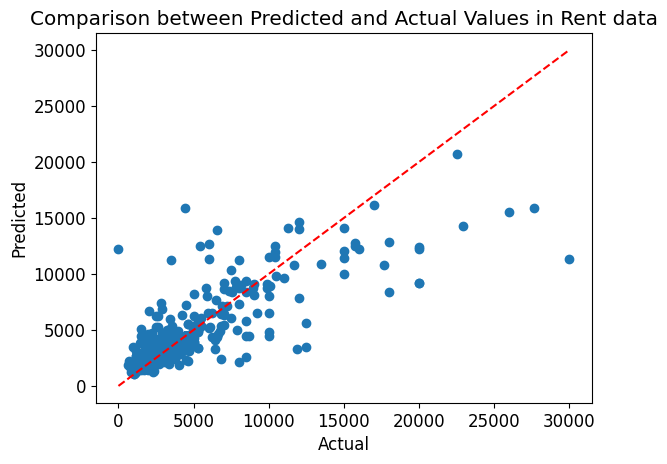

Text(0.5, 0, 'Actual')

Text(0, 0.5, 'Predicted')

Text(0.5, 1.0, 'Comparison between Predicted and Actual Values in Sold data')

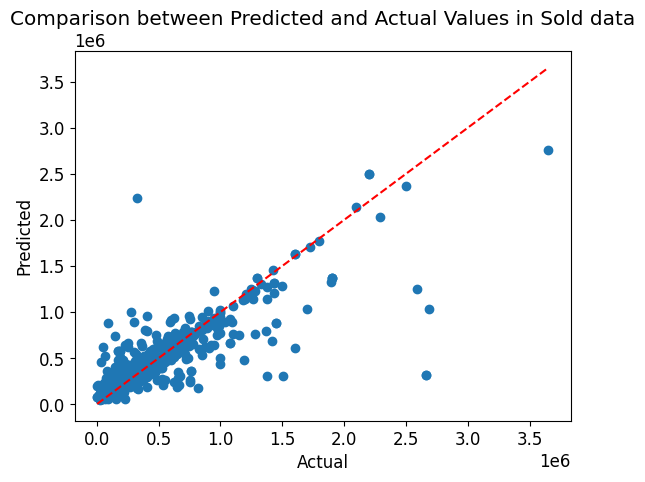

In [276]:
plt.scatter(rent_Y_test_rf, rent_Y_pred_rf)
plt.plot([min(rent_Y_test_rf), max(rent_Y_test_rf)], [min(rent_Y_test_rf), max(rent_Y_test_rf)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Comparison between Predicted and Actual Values in Rent data')
plt.show()


plt.scatter(sold_Y_test_rf, sold_Y_pred_rf)
plt.plot([min(sold_Y_test_rf), max(sold_Y_test_rf)], [min(sold_Y_test_rf), max(sold_Y_test_rf)], color='red', linestyle='--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Comparison between Predicted and Actual Values in Sold data')
plt.show()